In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def analytical_q(pars):
    numerator = pars['a01']*((pars['a10']*pars['T0'])-(pars['a01']*pars['T1']))
    denominator = (pars['a00']*pars['gamma1']) + (pars['a11']*pars['gamma0'])
    
    return pars['kb']*(numerator/denominator)

In [3]:
def analytical_soln_acf_generic(omega_list, pars):

    autocorr_list = []
    for omega in omega_list:
        numerator = ( pars['a11']**2 * pars['noise0'] ) \
        + ( pars['a01']**2 * pars['noise1'] ) \
        + ( (omega**2) * (pars['gamma1']**2) * (pars['noise0']) )

        denominator = ( -2*pars['a11']*pars['a00']*pars['a10']*pars['a01'] ) \
        + ( (omega**2) * (pars['gamma0']**2) * (pars['a11']**2) ) \
        + ( ( (pars['a10']*pars['a01']) + (pars['gamma0']*pars['gamma1']* (omega**2) ) )**2) \
        + ( (pars['a00']**2) * ( (pars['a11']**2) + ((omega**2) * (pars['gamma1']**2) ) ))

        autocorr = numerator/denominator
        autocorr_list.append(autocorr)
    return autocorr_list

In [4]:
def analytical_soln_real_response(omega_list, pars):
    real_response_list = []
    for omega in omega_list:
        numerator = - (omega**2)*(pars['gamma1']**2)*pars['a00'] \
        - (pars['a11']**2)*pars['a00'] \
        + pars['a10']*pars['a01']*pars['a11']
        
        denominator = ( -2*pars['a11']*pars['a00']*pars['a10']*pars['a01'] ) \
        + ( (omega**2) * (pars['gamma0']**2) * (pars['a11']**2) ) \
        + ( ( (pars['a10']*pars['a01']) + (pars['gamma0']*pars['gamma1']* (omega**2) ) )**2) \
        + ( (pars['a00']**2) * ( (pars['a11']**2) + ((omega**2) * (pars['gamma1']**2) ) ))
        
        real_response = numerator/denominator
        real_response_list.append(real_response)
    return real_response_list

In [5]:
def analytical_soln_imaginary_response(omega_list, pars):
    im_response_list = []
    for omega in omega_list:
        numerator = omega*(
            (pars['gamma1']*pars['a10']*pars['a01']) \
            + (pars['gamma0']*(pars['gamma1']**2)*(omega**2)) \
            + ((pars['a11']**2)*pars['gamma0'])
        )
        
        denominator = ( -2*pars['a11']*pars['a00']*pars['a10']*pars['a01'] ) \
        + ( (omega**2) * (pars['gamma0']**2) * (pars['a11']**2) ) \
        + ( ( (pars['a10']*pars['a01']) + (pars['gamma0']*pars['gamma1']* (omega**2) ) )**2) \
        + ( (pars['a00']**2) * ( (pars['a11']**2) + ((omega**2) * (pars['gamma1']**2) ) ))
        
        im_response = numerator/denominator
        im_response_list.append(im_response)
    return im_response_list

In [6]:
#paramaters
#change all units to: force = pN, length = nm, time = ms
pars = {}
pars['a00'] = -1
pars['a01'] = -0
pars['a10'] = -0.5
pars['a11'] = -1
pars['gamma0'] = 1
pars['gamma1'] = 1

pars['kb'] = 1.38*10**-2

pars['T0'] = 300
pars['T1'] = 300
pars['noise0'] = 2*pars['gamma0']*pars['kb']*pars['T0']
pars['noise1'] = 2*pars['gamma1']*pars['kb']*pars['T1']

In [7]:
(pars['a00']*pars['a11']) - (pars['a01']*pars['a10'])

1.0

In [8]:
omega_list = np.linspace(-200, 200, 1000)
def calculate_energy_diss(pars, omega_list):
    
    paper_acf_soln = analytical_soln_acf_generic(omega_list, pars)
    paper_imaginary_soln = analytical_soln_imaginary_response(omega_list, pars)
    final_imaginary = (np.array(2*pars['kb']*pars['T0']*omega_list)*np.array(paper_imaginary_soln))

    delta_omega = omega_list[1] - omega_list[0]
    omega_squared = (omega_list)**2

    #paper_acf_soln is autocrrelation function
    #final_imaginary is imaginary of response function * (2*kBT/omega)
    violation_function = (pars['gamma0']/(2*np.pi))*(omega_squared*paper_acf_soln - final_imaginary)
    #energy dissipated is the integral of the violation_function
    energy_diss = np.sum(violation_function*delta_omega)
    return energy_diss, paper_acf_soln, final_imaginary

In [9]:
a01_list = np.arange(0, 0.5 + 0.01, 0.01)
a01_list_final = np.array(-1)*a01_list
a01_list_final

array([-0.  , -0.01, -0.02, -0.03, -0.04, -0.05, -0.06, -0.07, -0.08,
       -0.09, -0.1 , -0.11, -0.12, -0.13, -0.14, -0.15, -0.16, -0.17,
       -0.18, -0.19, -0.2 , -0.21, -0.22, -0.23, -0.24, -0.25, -0.26,
       -0.27, -0.28, -0.29, -0.3 , -0.31, -0.32, -0.33, -0.34, -0.35,
       -0.36, -0.37, -0.38, -0.39, -0.4 , -0.41, -0.42, -0.43, -0.44,
       -0.45, -0.46, -0.47, -0.48, -0.49, -0.5 ])

In [10]:
energy_diss_list = []
q_list = []
for i in tqdm(a01_list_final):
    pars['a01'] = i
    energy_diss, paper_acf_soln, final_imaginary = calculate_energy_diss(pars, omega_list)
    energy_diss_list.append(energy_diss)
    
    q_analytical = analytical_q(pars)
    q_list.append(q_analytical)

100%|██████████| 51/51 [00:00<00:00, 63.86it/s]


In [11]:
# import pickle
# with open('energy_diss.pkl', 'wb') as f:
#     pickle.dump(energy_diss_list, f)

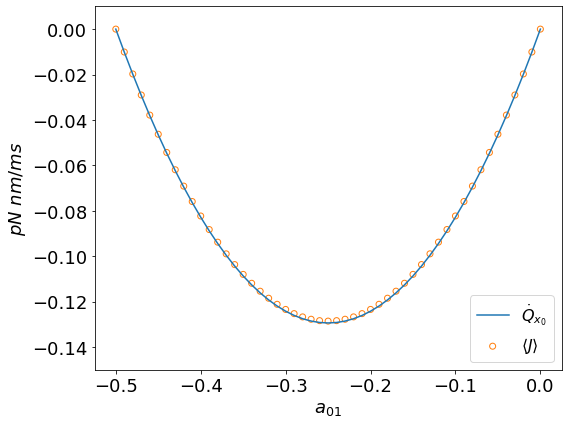

In [15]:
fig = plt.figure(figsize=(8,6))

plt.scatter(a01_list_final, energy_diss_list,  facecolors='none', edgecolors='tab:orange', label='$\\left<J\\right>$')
plt.plot(a01_list_final, q_list, color='tab:blue', label='$\dot{Q}_{x_0}$')
plt.xlabel('$a_{01}$', fontsize=18)
plt.ylabel('$pN$ $nm/ms$', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.15,0.01)
plt.legend(loc='lower right', fontsize=16)
plt.tight_layout()
plt.savefig('reciprocity_j_q_fin.png', dpi=300)
plt.show()